In [5]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from unet.unet import *
import numpy as np
import seaborn as sns

In [6]:
PATH_TO_MODEL = "checkpoints/detector_epoch_50.pth"
PATH_TO_TRAIN_LOSS = "checkpoints/1train_loss"
PATH_TO_VALIDATION_LOSS = "checkpoints/1validation_loss"

In [7]:
test_X = torch.load('data/testX')
test_Y = torch.load('data/testY')
test_ymu =  torch.load('data/test_ymu').cuda()
test_ystd = torch.load('data/test_ystd').cuda()

In [8]:
%%capture
model = UNet(10,2)
model.load_state_dict(torch.load(PATH_TO_MODEL,map_location='cuda:0'))
model.eval()
model.cuda()

In [9]:
sample_errs = []
pixel_errs = torch.empty_like(test_Y)
for i in range(test_X.size(0)):
    with torch.no_grad():
        x = test_X[i:i+1].cuda()
        yhat = model(x)
        
        # Invert standardization to original units
        yhat = yhat*test_ystd + test_ymu
        y = test_Y[i:i+1]*test_ystd.cpu() + test_ymu.cpu()

        err = torch.abs(torch.abs(y-yhat.cpu())/y)
        sample_errs.append(err.mean())
        pixel_errs[i] = err
sample_errs = np.array(sample_errs)

### Percentage Errors per sample

# sample_errs.mean(),sample_errs.std()

### Percentage Errors per pixel

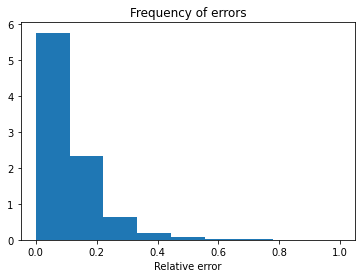

In [10]:
plt.hist(x = pixel_errs.reshape(-1).numpy(),density=True,bins=np.linspace(0,1,10))
plt.xlabel("Relative error")
plt.title("Frequency of errors")
plt.savefig("errhist.png", dpi=500)

### Percentage of pixels with under 20% error

In [22]:
(pixel_errs < 0.2)[:,0,:,:,:].float().mean(), (pixel_errs < 0.2)[:,1,:,:,:].float().mean()

(tensor(0.8017), tensor(0.9326))

### Heat map of error for a sample cross-section

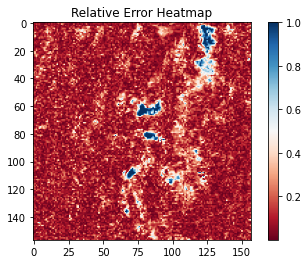

In [31]:
plt.imshow(pixel_errs[0,0,0].clip(0,1), cmap='RdBu')
plt.colorbar()
plt.title("Relative Error Heatmap")
plt.savefig("errheat.png", dpi=500)